In [4]:
# Pkg.add("LowRankModels")
# Pkg.update()
# Pkg.add("SCS")

In [5]:
# Pkg.add("Gadfly")
using Convex
using DataFrames
using PyPlot
using SCS

In [6]:
include("proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [7]:
# load data
listings = readtable("listings_cleaned_smaller.csv")

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,property_type_apartment,property_type_bed_breakfast,property_type_boat,property_type_bungalow,property_type_cabin,property_type_camper_rv,property_type_castle,property_type_cave,property_type_chalet,property_type_condominium,property_type_dorm,property_type_earth_house,property_type_entire_floor,property_type_guesthouse,property_type_house,property_type_hut,property_type_lighthouse,property_type_loft,property_type_other,property_type_parking_space,property_type_plane,property_type_tent,property_type_tipi,property_type_townhouse,property_type_train,property_type_treehouse,property_type_villa,property_type_yurt,room_type_entire_home_apt,room_type_private_room,room_type_shared_room,bed_type_airbed,bed_type_couch,bed_type_futon,bed_type_pull_out_sofa,bed_type_real_bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_60
1,49,0.0,0.0,0,1,6,1,1,34.04206443,-118.2532204,1,3,1.0,1,1,18,0,180,0,15,1,0,2,2,0,0,0,0,2,100,10,10,10,10,10,10,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
2,35,1.0,1.0,1,1,4,1,1,34.09483054,-118.2644041,1,3,1.0,2,2,10,0,225,0,80,1,0,3,1125,0,0,15,283,38,99,10,9,10,10,10,10,0,1.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,52,0.87,0.93,0,1,4,1,1,34.11247523,-118.3364378,1,2,1.0,1,1,12,0,102,0,20,2,20,1,5,22,52,80,355,41,94,10,9,10,10,10,9,0,1.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,29,1.0,1.0,0,1,6,1,1,34.06455122,-118.4951368,0,3,1.0,1,2,14,0,330,0,0,1,0,1,1125,29,59,89,364,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
5,31,0.75,1.0,0,1,3,1,0,33.98847795,-118.4411853,1,2,1.0,1,1,23,0,125,0,0,1,0,1,1125,30,60,90,365,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
6,8,0.0,0.0,0,1,5,1,1,34.08636554,-118.3107836,1,2,1.0,1,1,17,0,50,0,0,1,0,1,1125,0,0,0,214,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
7,6,0.0,1.0,0,1,1,1,0,33.92738545,-118.2697351,1,2,2.0,1,2,13,0,50,100,20,1,0,5,1125,28,58,88,88,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
8,3,0.0,0.0,0,1,2,1,0,34.06783664,-118.3492394,1,2,1.5,1,1,17,0,350,0,0,1,0,1,1125,29,29,29,29,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
9,26,0.0,0.0,0,1,5,1,1,34.04959846,-118.4633752,1,1,1.0,1,1,17,0,100,445,0,1,0,1,1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
10,17,1.0,0.9,0,1,6,1,1,34.08844529,-118.3551676,1,3,1.0,1,1,17,0,65,0,0,1,15,1,1125,1,3,33,308,21,88,9,9,9,9,9,9,0,1.74,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0


In [8]:
# fit a linear model
x = copy(listings)
x[:offset] = 1
# delete!(x, :price)
x

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,property_type_apartment,property_type_bed_breakfast,property_type_boat,property_type_bungalow,property_type_cabin,property_type_camper_rv,property_type_castle,property_type_cave,property_type_chalet,property_type_condominium,property_type_dorm,property_type_earth_house,property_type_entire_floor,property_type_guesthouse,property_type_house,property_type_hut,property_type_lighthouse,property_type_loft,property_type_other,property_type_parking_space,property_type_plane,property_type_tent,property_type_tipi,property_type_townhouse,property_type_train,property_type_treehouse,property_type_villa,property_type_yurt,room_type_entire_home_apt,room_type_private_room,room_type_shared_room,bed_type_airbed,bed_type_couch,bed_type_futon,bed_type_pull_out_sofa,bed_type_real_bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_60,offset
1,49,0.0,0.0,0,1,6,1,1,34.04206443,-118.2532204,1,3,1.0,1,1,18,0,180,0,15,1,0,2,2,0,0,0,0,2,100,10,10,10,10,10,10,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
2,35,1.0,1.0,1,1,4,1,1,34.09483054,-118.2644041,1,3,1.0,2,2,10,0,225,0,80,1,0,3,1125,0,0,15,283,38,99,10,9,10,10,10,10,0,1.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,52,0.87,0.93,0,1,4,1,1,34.11247523,-118.3364378,1,2,1.0,1,1,12,0,102,0,20,2,20,1,5,22,52,80,355,41,94,10,9,10,10,10,9,0,1.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
4,29,1.0,1.0,0,1,6,1,1,34.06455122,-118.4951368,0,3,1.0,1,2,14,0,330,0,0,1,0,1,1125,29,59,89,364,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
5,31,0.75,1.0,0,1,3,1,0,33.98847795,-118.4411853,1,2,1.0,1,1,23,0,125,0,0,1,0,1,1125,30,60,90,365,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
6,8,0.0,0.0,0,1,5,1,1,34.08636554,-118.3107836,1,2,1.0,1,1,17,0,50,0,0,1,0,1,1125,0,0,0,214,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
7,6,0.0,1.0,0,1,1,1,0,33.92738545,-118.2697351,1,2,2.0,1,2,13,0,50,100,20,1,0,5,1125,28,58,88,88,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
8,3,0.0,0.0,0,1,2,1,0,34.06783664,-118.3492394,1,2,1.5,1,1,17,0,350,0,0,1,0,1,1125,29,29,29,29,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
9,26,0.0,0.0,0,1,5,1,1,34.04959846,-118.4633752,1,1,1.0,1,1,17,0,100,445,0,1,0,1,1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
10,17,1.0,0.9,0,1,6,1,1,34.08844529,-118.3551676,1,3,1.0,1,1,17,0,65,0,0,1,15,1,1125,1,3,33,308,21,88,9,9,9,9,9,9,0,1.74,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


In [9]:
# smalldata = x[1:10, [:accommodates, :bathrooms, :beds, :amenities, :number_of_reviews, :review_scores_rating]]
n = 10
x1 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :amenities, :review_scores_rating, :offset]])
x2 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :offset]])
x3 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :room_type_entire_home_apt, :offset]])
x4 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :room_type_entire_home_apt, :reviews_per_month, :offset]])
x5 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :bed_type_real_bed, :room_type_entire_home_apt, :reviews_per_month, :property_type_apartment, :offset]])

y = convert(Array{Float64}, x[1:n, [:price]])
y = y[:,1]

10-element Array{Float64,1}:
 180.0
 225.0
 102.0
 330.0
 125.0
  50.0
  50.0
 350.0
 100.0
  65.0

In [10]:
function lasso(X,y; λ=1)
    @show d = size(X,2)
    @show w = Variable(d)
    @show p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

function nnls(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y), w>=0)
    solve!(p)
    return w.value
end

function logisticLoss(X,y)
    # solve the logistic regression problem
    n, p = size(X)
    w = Variable(p)
    problem = minimize(logisticloss(-y.*(X*w)))
    solve!(problem, SCSSolver(verbose=false))
    return w.value
end

function ols(x, y)
    return x\y
end

function test(w, x, y)
    f(x_i) = vecdot(w,x_i)
    total_error = 0
    for i = 1:size(x,1)
        actual = y[i]
        predicted = f(x[i,:])
        total_error += abs(actual - predicted)
    end
    return total_error
end

test (generic function with 1 method)

In [25]:
n = length(y)

# huber regression
w_huber1 = proxgrad(1/n*HuberLoss(), ZeroReg(), x1, y, maxiters=200)
w_huber2 = proxgrad(1/n*HuberLoss(), ZeroReg(), x2, y, maxiters=200)
w_huber3 = proxgrad(1/n*HuberLoss(), ZeroReg(), x3, y, maxiters=200)
w_huber4 = proxgrad(1/n*HuberLoss(), ZeroReg(), x4, y, maxiters=200)
w_huber5 = proxgrad(1/n*HuberLoss(), ZeroReg(), x5, y, maxiters=200)

@show err_huber1 = test(w_huber1, x1, y)
@show err_huber2 = test(w_huber2, x2, y)
@show err_huber3 = test(w_huber3, x3, y)
@show err_huber4 = test(w_huber4, x4, y)
@show err_huber5 = test(w_huber5, x5, y)

# ordinary least squares regression
lambda = 1
w_quad1 = proxgrad(1/n*QuadLoss(), ZeroReg(), x1, y, maxiters=200)
w_quad2 = proxgrad(1/n*QuadLoss(), ZeroReg(), x2, y, maxiters=200)
w_quad3 = proxgrad(1/n*QuadLoss(), ZeroReg(), x3, y, maxiters=200)
w_quad4 = proxgrad(1/n*QuadLoss(), ZeroReg(), x4, y, maxiters=200)
w_quad5 = proxgrad(1/n*QuadLoss(), ZeroReg(), x5, y, maxiters=200)
w_quad5_l1 = proxgrad(1/n*QuadLoss(), OneReg(lambda), x5, y, maxiters=200)
w_quad5_l2 = proxgrad(1/n*QuadLoss(), QuadReg(lambda), x5, y, maxiters=200)

@show err_quad1 = test(w_quad1, x1, y)
@show err_quad2 = test(w_quad2, x2, y)
@show err_quad3 = test(w_quad3, x3, y)
@show err_quad4 = test(w_quad4, x4, y)
@show err_quad5 = test(w_quad5, x5, y)
@show err_quad5_l1 = test(w_quad5_l1, x5, y)
@show err_quad5_l2 = test(w_quad5_l2, x5, y)

# l1 loss regression
w_l1_1 = proxgrad(1/n*L1Loss(), ZeroReg(), x1, y, maxiters=200)
w_l1_2 = proxgrad(1/n*L1Loss(), ZeroReg(), x2, y, maxiters=200)
w_l1_3 = proxgrad(1/n*L1Loss(), ZeroReg(), x3, y, maxiters=200)
w_l1_4 = proxgrad(1/n*L1Loss(), ZeroReg(), x4, y, maxiters=200)
w_l1_5 = proxgrad(1/n*L1Loss(), ZeroReg(), x5, y, maxiters=200)

@show err_l1_1 = test(w_l1_1, x1, y)
@show err_l1_2 = test(w_l1_2, x2, y)
@show err_l1_3 = test(w_l1_3, x3, y)
@show err_l1_4 = test(w_l1_4, x4, y)
@show err_l1_5 = test(w_l1_5, x5, y)

# quantile regression
w_quantile5 = proxgrad(1/n*QuantileLoss(quantile=.4), ZeroReg(), x5, y, maxiters=1000)
@show err_quantile5 = test(w_quantile5, x5, y)



err_huber1 = test(w_huber1,x1,y) = 837.3989573683035
err_huber2 = test(w_huber2,x2,y) = 714.4838689586778
err_huber3 = test(w_huber3,x3,y) = 678.108688375047
err_huber4 = test(w_huber4,x4,y) = 633.4165413594731
err_huber5 = test(w_huber5,x5,y) = 628.9830104613864
err_quad1 = test(w_quad1,x1,y) = 926.780955229574
err_quad2 = test(w_quad2,x2,y) = 711.2140160575544
err_quad3 = test(w_quad3,x3,y) = 729.95508975294
err_quad4 = test(w_quad4,x4,y) = 608.0243370499232
err_quad5 = test(w_quad5,x5,y) = 605.1781190601179
err_quad5_l1 = test(w_quad5_l1,x5,y) = 606.2897315051955
err_quad5_l2 = test(w_quad5_l2,x5,y) = 689.611160576626
err_l1_1 = test(w_l1_1,x1,y) = 868.546075012743
err_l1_2 = test(w_l1_2,x2,y) = 721.2999999999998
err_l1_3 = test(w_l1_3,x3,y) = 700.7499999999998
err_l1_4 = test(w_l1_4,x4,y) = 699.0201591601563
err_l1_5 = test(w_l1_5,x5,y) = 688.7541614551544
err_quantile5 = test(w_quantile5,x5,y) = 634.045735323548


634.045735323548

In [171]:
X = convert(Array, x)
Y = convert(Array, listings[:price])

@show w_ols = X\Y

w_ols = X \ Y = [-9.80038e-6,0.000312973,-5.98727e-5,-3.09969e-5,-0.000729442,0.000454819,-2.33247e-6,-0.000746137,-0.000344826,-9.37802e-5,-0.000408708,-0.000149432,0.000507532,0.000224552,0.000125011,2.17129e-5,0.0,0.999995,1.88204e-7,4.26541e-6,-0.000118758,-3.05783e-5,1.48574e-5,-2.89656e-8,5.73505e-5,-1.44054e-5,-4.46218e-6,1.9397e-7,1.01752e-5,3.05944e-5,-0.000279599,0.000364493,-0.000223205,-9.71561e-5,0.000588686,-0.000637523,1.00946e-5,-4.82823e-5,0.000135497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000424043,0.0,0.0,0.0,0.0,0.000235712,0.0,0.0,-0.000289817,0.0,0.0,0.0,0.0,0.0,-0.000507767,0.0,0.0,0.0,0.0,0.000132922,-0.000576242,0.000440987,0.0,0.0,-0.000492493,0.000308647,0.000181513,-9.08479e-5,8.90702e-5,0.0,-5.54768e-7,0.0,-2.33247e-6]


80-element Array{Float64,1}:
 -9.80038e-6 
  0.000312973
 -5.98727e-5 
 -3.09969e-5 
 -0.000729442
  0.000454819
 -2.33247e-6 
 -0.000746137
 -0.000344826
 -9.37802e-5 
 -0.000408708
 -0.000149432
  0.000507532
  ⋮          
  0.000440987
  0.0        
  0.0        
 -0.000492493
  0.000308647
  0.000181513
 -9.08479e-5 
  8.90702e-5 
  0.0        
 -5.54768e-7 
  0.0        
 -2.33247e-6 

In [24]:
f(x) = sum(w_ols.*x)

x1 = X[1,:]
x2 = X[2,:]
x3 = X[3,:]
@show f(x1)
@show f(x2)
@show f(x3)

f(x1) = 365.4265387931242
f(x2) = 1911.5774465376546
f(x3) = 851.6519914949397


851.6519914949397

In [33]:
w_ridge = ridge_regression(X, Y)

----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1339
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 84, constraints m = 129
Cones:	primal zero / dual free vars: 1
	linear vars: 2
	soc vars: 126, soc blks: 4
Setup time: 2.94e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  3.68e-05 
   100|      inf       inf      -nan       inf       inf       inf  8.26e-04 
   200|      inf       inf      -nan       inf       inf       inf  1.57e-03 
   300|      inf       inf  

79x1 Array{Float64,2}:
  -0.768017 
 -35.4473   
  -5.00595  
 -12.1527   
 -12.9236   
  64.0255   
  -0.0354456
 -21.3568   
  -0.110354 
   2.04221  
   1.38592  
  68.0459   
  74.0347   
   ⋮        
  32.0549   
   0.0      
   0.0      
 -17.426    
  14.3669   
   3.02358  
  43.1347   
   9.39121  
   0.0      
 -52.5614   
   0.0      
  -0.0354456

In [34]:
w_lasso = lasso(X, Y)

d = size(X,2) = 79
w = Variable(d) = Variable of
size: (79, 1)
sign: Convex.NoSign()
vexity: Convex.AffineVexity()
p = minimize(sumsquares(X * w - y) + λ * norm(w,1)) = Problem:
minimize AbstractExpr with
head: +
size: (1, 1)
sign: Convex.Positive()
vexity: Convex.ConvexVexity()

subject to

current status: not yet solved
----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1650
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 161, constraints m = 203
Cones:	primal zero / dual free vars: 1
	linear vars: 159
	soc vars: 43, soc blks: 2
Setup time: 4.13e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-------------

79x1 Array{Float64,2}:
   -2.03196    
   80.2853     
  -19.7183     
  -28.6967     
 -237.666      
   93.0402     
    7.42607e-8 
 -152.433      
    8.59223e-6 
   -0.664782   
 -111.952      
  -47.66       
  137.785      
    ⋮          
  106.611      
    0.0        
    0.0        
 -161.57       
    2.01502    
   -1.99248e-5 
  -43.5329     
   -0.000170396
    0.0        
   -2.09318e-5 
    0.0        
    7.42607e-8 

In [35]:
w_nonneg = nnls(X, Y)

----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1334
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 82, constraints m = 124
Cones:	primal zero / dual free vars: 1
	linear vars: 80
	soc vars: 43, soc blks: 2
Setup time: 3.04e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  3.70e-05 
   100|      inf       inf      -nan       inf       inf       inf  8.13e-04 
   200|      inf       inf      -nan       inf       inf       inf  1.55e-03 
   300|      inf       inf  

79x1 Array{Float64,2}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

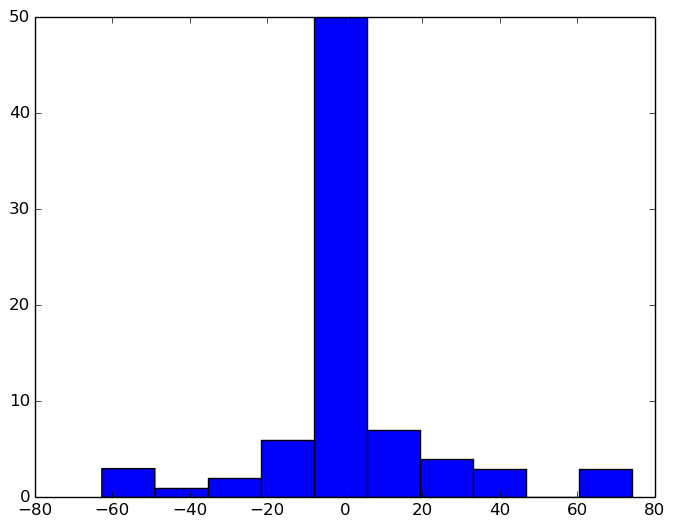

([3.0,1.0,2.0,6.0,50.0,7.0,4.0,3.0,0.0,3.0],[-62.69175558506094,-49.01911008867207,-35.346464592283205,-21.673819095894338,-8.00117359950547,5.671471896883396,19.344117393272263,33.01676288966113,46.68940838605,60.362053882438865,74.03469937882772],Any[PyObject <matplotlib.patches.Rectangle object at 0x7ff717822d90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717831410>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717831a90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717831f90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71783c7d0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71783ce50>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71784a510>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71784ab90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff7177d6250>,PyObject <matplotlib.patches.Rectangle object at 0x7ff7177d6750>])

In [43]:
plt[:hist](w_ridge)

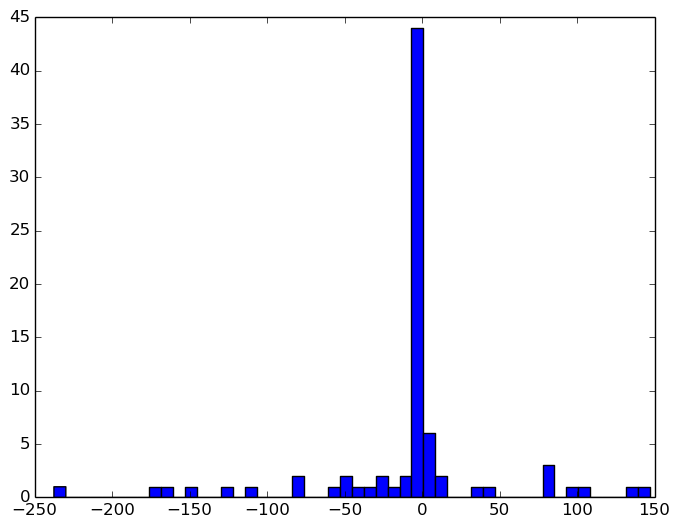

([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0  …  0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0],[-237.666,-229.977,-222.289,-214.6,-206.911,-199.222,-191.533,-183.845,-176.156,-168.467  …  77.5748,85.2636,92.9524,100.641,108.33,116.019,123.708,131.396,139.085,146.774],Any[PyObject <matplotlib.patches.Rectangle object at 0x7ff71770d450>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71770da90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71770df90>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71771c4d0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71771c9d0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff71771ced0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717729410>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717729910>,PyObject <matplotlib.patches.Rectangle object at 0x7ff717729e10>,PyObject <matplotlib.patches.Rectangle object at 0x7ff7177354d0>  …  PyObject <matplotlib.patches.Rectangle object at 0x7ff71785f5d0>,PyObject <matplot

In [44]:
plt[:hist](w_lasso, bins=50)

In [38]:
plt[:hist](w_nonneg)

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.AttributeError'>
AttributeError('max must be larger than min in range parameter.',)
  File "/usr/lib/pymodules/python2.7/matplotlib/pyplot.py", line 2827, in hist
    stacked=stacked, **kwargs)
  File "/usr/lib/pymodules/python2.7/matplotlib/axes.py", line 8326, in hist
    m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
  File "/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py", line 165, in histogram
    'max must be larger than min in range parameter.')

while loading In[38], in expression starting on line 1